---
title: "Reports"
output: html_notebook
execute:
  eval: true
  echo: false
jupyter: python3
---

In [ ]:
%load_ext kedro.ipython

In [ ]:
from kedro.session import KedroSession

catalog = KedroSession.DatasetCatalog("conf/base/catalog.yml")
model_metrics = catalog.load("model_metrics")
conformal_metrics = catalog.load("cp_metrics")
ood_metrics = catalog.load("ood_detection_metrics")

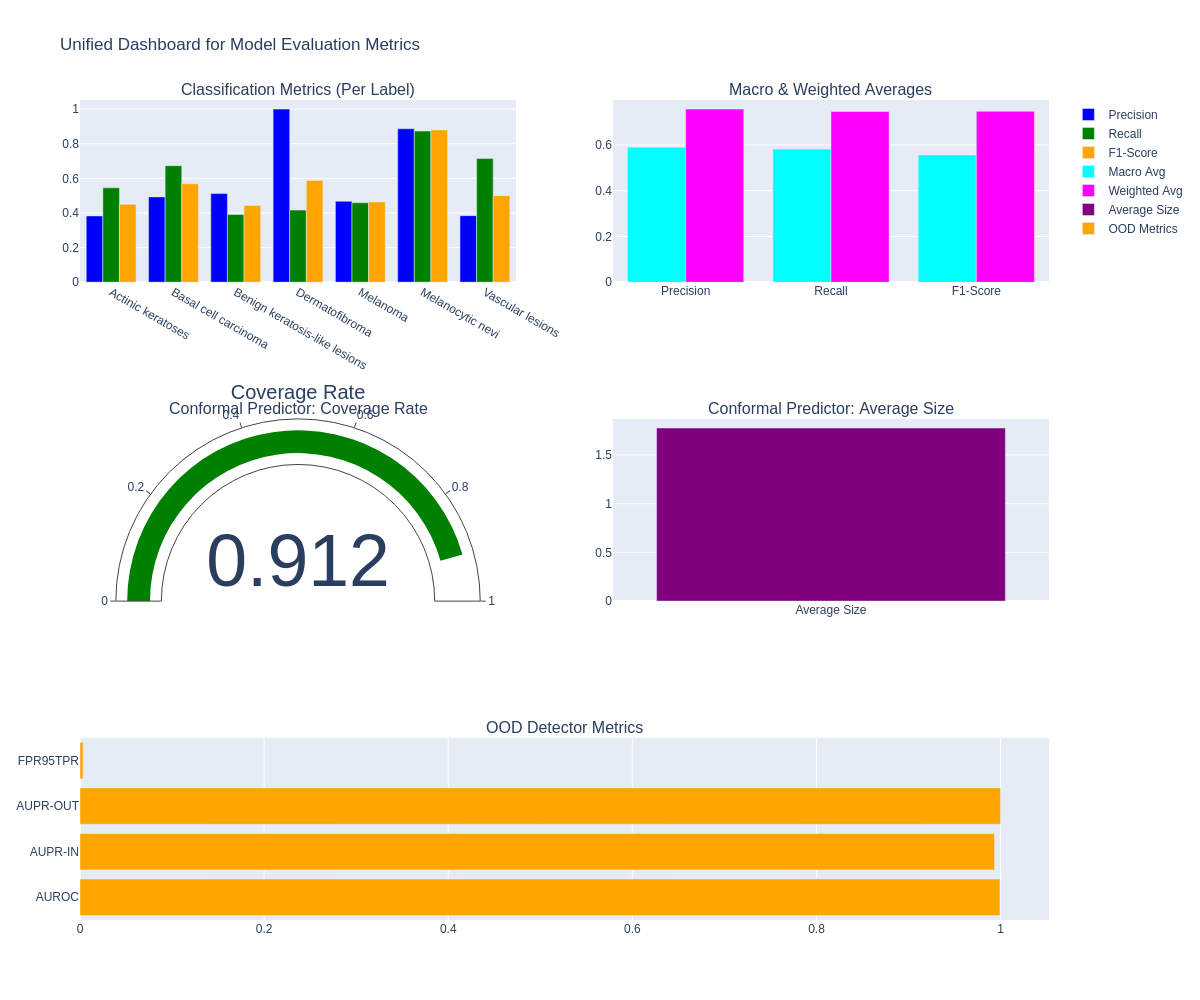

In [3]:
import plotly.graph_objects as go
from IPython.display import Image
from plotly.subplots import make_subplots

# Disease labels
disease_labels = [
    "Actinic keratoses",
    "Basal cell carcinoma",
    "Benign keratosis-like lesions",
    "Dermatofibroma",
    "Melanoma",
    "Melanocytic nevi",
    "Vascular lesions",
]

# Extract classification metrics
labels = list(model_metrics.keys())[
    :-3
]  # Exclude "accuracy", "macro avg", "weighted avg"
precision = [model_metrics[label]["precision"] for label in labels]
recall = [model_metrics[label]["recall"] for label in labels]
f1_score = [model_metrics[label]["f1-score"] for label in labels]

# Extract macro and weighted averages
macro_avg = model_metrics["macro avg"]
weighted_avg = model_metrics["weighted avg"]

# Initialize subplots
fig = make_subplots(
    rows=3,
    cols=2,
    specs=[
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "indicator"}, {"type": "bar"}],
        [{"type": "bar", "colspan": 2}, None],
    ],
    subplot_titles=[
        "Classification Metrics (Per Label)",
        "Macro & Weighted Averages",
        "Conformal Predictor: Coverage Rate",
        "Conformal Predictor: Average Size",
        "OOD Detector Metrics",
    ],
)

# Add per-label classification metrics
fig.add_trace(
    go.Bar(name="Precision", x=disease_labels, y=precision, marker=dict(color="blue")),
    row=1,
    col=1,
)
fig.add_trace(
    go.Bar(name="Recall", x=disease_labels, y=recall, marker=dict(color="green")),
    row=1,
    col=1,
)
fig.add_trace(
    go.Bar(name="F1-Score", x=disease_labels, y=f1_score, marker=dict(color="orange")),
    row=1,
    col=1,
)

# Add macro and weighted averages
fig.add_trace(
    go.Bar(
        name="Macro Avg",
        x=["Precision", "Recall", "F1-Score"],
        y=[macro_avg["precision"], macro_avg["recall"], macro_avg["f1-score"]],
        marker=dict(color="cyan"),
    ),
    row=1,
    col=2,
)
fig.add_trace(
    go.Bar(
        name="Weighted Avg",
        x=["Precision", "Recall", "F1-Score"],
        y=[weighted_avg["precision"], weighted_avg["recall"], weighted_avg["f1-score"]],
        marker=dict(color="magenta"),
    ),
    row=1,
    col=2,
)

# Add conformal predictor metrics
fig.add_trace(
    go.Indicator(
        mode="gauge+number",
        value=conformal_metrics["Coverage_rate"],
        title={"text": "Coverage Rate"},
        gauge={"axis": {"range": [0, 1]}, "bar": {"color": "green"}},
    ),
    row=2,
    col=1,
)
fig.add_trace(
    go.Bar(
        name="Average Size",
        x=["Average Size"],
        y=[conformal_metrics["Average_size"]],
        marker=dict(color="purple"),
    ),
    row=2,
    col=2,
)

# Add OOD detector metrics
ood_names = list(ood_metrics.keys())
ood_values = list(ood_metrics.values())
fig.add_trace(
    go.Bar(
        name="OOD Metrics",
        x=ood_values,
        y=ood_names,
        orientation="h",
        marker=dict(color="orange"),
    ),
    row=3,
    col=1,
)

# Update layout to show legend and for better spacing
fig.update_layout(
    title="Unified Dashboard for Model Evaluation Metrics",
    barmode="group",
    height=1000,
    width=1200,
    showlegend=True,  # Ensure legend is shown
)

# Show the figure as a PNG
fig.write_image("./images/report.png")

Image(filename="./images/report.png")

## OOD Detection Metrics

1. **AUROC (Area Under the Receiver Operating Characteristic Curve)**:

   - This metric evaluates the ability of the model to distinguish between in-distribution and out-of-distribution data. It represents the area under the ROC curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various thresholds.
   - **Higher is Better**: A value close to 1 indicates that the model has a high capability to correctly classify in-distribution vs. out-of-distribution examples.

2. **AUPR-IN (Area Under the Precision-Recall Curve for In-distribution data)**:

   - This metric focuses on the precision and recall of the model when identifying in-distribution data points. It calculates the area under the precision-recall curve for in-distribution data.
   - **Higher is Better**: A higher AUPR-IN value indicates that the model is better at correctly identifying in-distribution data and minimizing false positives (i.e., misclassifying out-of-distribution data as in-distribution).

3. **AUPR-OUT (Area Under the Precision-Recall Curve for Out-of-distribution data)**:

   - This metric evaluates the precision and recall for identifying out-of-distribution data points. It calculates the area under the precision-recall curve for out-of-distribution data.
   - **Higher is Better**: A higher AUPR-OUT indicates that the model is good at distinguishing out-of-distribution data from in-distribution data (low false positives and false negatives).

4. **FPR95TPR (False Positive Rate at 95% True Positive Rate)**:
   - \*This metric measures the False Positive Rate (FPR) when the True Positive Rate (TPR) is fixed at 95%. FPR represents the proportion of out-of-distribution samples incorrectly classified as in-distribution.
   - **Lower is Better**: A lower FPR at 95% TPR indicates that the model can correctly classify most out-of-distribution data points while maintaining high recall (95% TPR).
